<a href="https://colab.research.google.com/github/yai3xx/BaiduImageSpider/blob/master/notebooks/DepthPro_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook introduces inference with [DepthPro](https://huggingface.co/docs/transformers/main/en/model_doc/depthpro) model for depth estimation intorduced by Apple.

- DepthPro is zero-shot monocular **metric** depth estimation network.
- The whole network operates at a fixed resolution of 1536×1536 to achieve super sharp depth estimation while avoiding OOM errors for larger images.
- The network comes with an optional focal length estimation head. A small convolutional head, which ingests frozen features from the depth estimation network and task-specific features from a separate ViT image encoder to predict the horizontal angular field-of-view (FoV).

Abstract:  

*We present a foundation model for zero-shot metric monocular depth estimation. Our model, Depth Pro, synthesizes high-resolution depth maps with unparalleled sharpness and high-frequency details. The predictions are metric, with absolute scale, without relying on the availability of metadata such as camera intrinsics. And the model is fast, producing a 2.25-megapixel depth map in 0.3 seconds on a standard GPU. These characteristics are enabled by a number of technical contributions, including an efficient multi-scale vision transformer for dense prediction, a training protocol that combines real and synthetic datasets to achieve high metric accuracy alongside fine boundary tracing, dedicated evaluation metrics for boundary accuracy in estimated depth maps, and state-of-the-art focal length estimation from a single image. Extensive experiments analyze specific design choices and demonstrate that Depth Pro outperforms prior work along multiple dimensions.*

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/depth_pro_architecture.png)
![](https://github.com/apple/ml-depth-pro/blob/main/data/depth-pro-teaser.jpg?raw=true)



 - Paper: https://arxiv.org/abs/2410.02073
 - Project Page: https://promptda.github.io/

In this notebook we will cover the following steps:  

 - Loading an image
 - Loading pretrained model and image_processor from [HuggingFace Hub](https://huggingface.co/models?other=prompt_depth_anything)
 - Inference WITHOUT FoV (field of view)
 - Inference WITH FoV
 - Visualization of predicted depth maps

But first, let make sure we have the lates `transformers` installed:

In [1]:
!pip install -U -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import requests
import numpy as np

from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16

print(f"Device: {device}")

Device: cuda


### Load data

Image size: [2268, 3024]


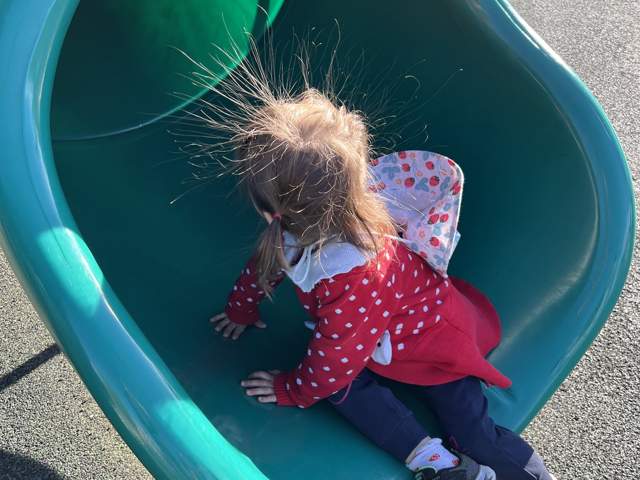

In [ ]:
# image for depth estimation
url = "https://pic-xxy.oss-cn-shenzhen.aliyuncs.com/img/fusion.bmp"
image = Image.open(requests.get(url, stream=True).raw)

print("Image size:", [image.height, image.width])
image.resize((640, 480)) # resize for visualization

### Load model and image processor from the Hugging Face Hub

Image processor is an object responsible for image normalization/resizing and results posprocessing, such as resizing depth map back to the image scale.

In [ ]:
checkpoint = "apple/DepthPro-hf"

image_processor = AutoImageProcessor.from_pretrained(checkpoint, use_fast=True)
model = AutoModelForDepthEstimation.from_pretrained(
    checkpoint, device_map=device, torch_dtype=dtype
)

# In case you don't need FoV and want to save some memory and compute
model_no_fov = AutoModelForDepthEstimation.from_pretrained(
    checkpoint, device_map=device, torch_dtype=dtype, use_fov_model=False
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

### Inference with FoV

In [ ]:
# Prepare image and prompt depth for the model
inputs = image_processor(images=image, return_tensors="pt")
inputs = inputs.to(device)
inputs["pixel_values"] = inputs["pixel_values"].to(dtype)

print(f"Preprocessed inputs: {inputs.keys()}")

with torch.no_grad():
    outputs = model(**inputs)

print(f"Model outputs: {outputs.keys()}")
print(f"Model predicted depth (raw) shape: {outputs['predicted_depth'].shape}")

# interpolate to original size
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)
post_processed_output

Preprocessed inputs: dict_keys(['pixel_values'])
Model outputs: odict_keys(['predicted_depth', 'field_of_view'])
Model predicted depth (raw) shape: torch.Size([1, 1536, 1536])


[{'predicted_depth': tensor([[0.9614, 0.9341, 0.8853,  ..., 3.0156, 2.9746, 2.9551],
          [0.9219, 0.9004, 0.8613,  ..., 3.0176, 3.0156, 3.0137],
          [0.8818, 0.8662, 0.8374,  ..., 3.0293, 3.0508, 3.0605],
          ...,
          [1.2305, 1.2285, 1.2246,  ..., 1.2715, 1.2832, 1.2891],
          [1.2246, 1.2256, 1.2285,  ..., 1.2686, 1.2812, 1.2891],
          [1.2178, 1.2236, 1.2354,  ..., 1.2666, 1.2764, 1.2822]],
         device='cuda:0', dtype=torch.float16),
  'field_of_view': tensor(48.4375, device='cuda:0', dtype=torch.float16),
  'focal_length': tensor(3364., device='cuda:0', dtype=torch.float16)}]

In [ ]:
predicted_depth = post_processed_output[0]["predicted_depth"]

min = predicted_depth.min().item()
max = predicted_depth.max().item()

print("Predicted depth shape:", predicted_depth.shape)
print(f"Predicted depth range: {min:.2f}..{max:.2f} (meters)")

Predicted depth shape: torch.Size([2268, 3024])
Predicted depth range: 0.61..3.08 (meters)


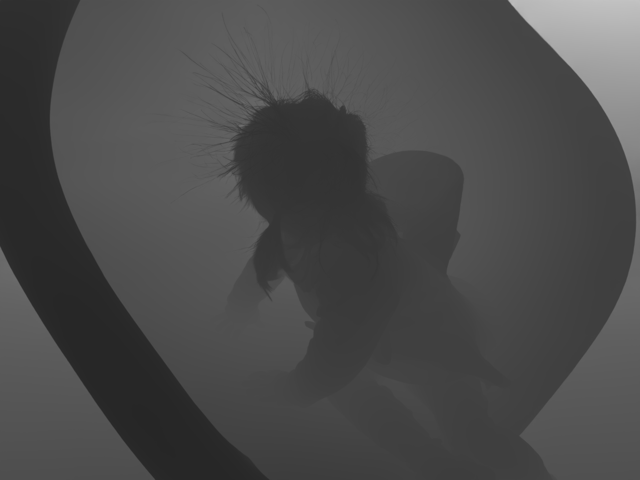

In [ ]:
# Visualize the prediction
# Let's normalize it with respect to 4 meters depth (beacuse maximum depth is 3.08)
# JUST for visualization and comparison with NO FoV model
max_depth = 4
normalized_depth = predicted_depth.cpu().numpy() / max_depth
normalized_depth = Image.fromarray((normalized_depth * 255).astype("uint8"))

normalized_depth.resize([640, 480])

### Inference without FoV

In [ ]:
# Prepare image and prompt depth for the model
inputs = image_processor(images=image, return_tensors="pt")
inputs = inputs.to(device)
inputs["pixel_values"] = inputs["pixel_values"].to(dtype)

print(f"Preprocessed inputs: {inputs.keys()}")

with torch.no_grad():
    outputs = model_no_fov(**inputs)

print(f"Model outputs: {outputs.keys()}")
print(f"Model predicted depth (raw) shape: {outputs['predicted_depth'].shape}")

# interpolate to original size
post_processed_outputno_fov = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)
post_processed_outputno_fov

Preprocessed inputs: dict_keys(['pixel_values'])
Model outputs: odict_keys(['predicted_depth'])
Model predicted depth (raw) shape: torch.Size([1, 1536, 1536])


[{'predicted_depth': tensor([[0.8643, 0.8394, 0.7954,  ..., 2.7109, 2.6738, 2.6562],
          [0.8286, 0.8091, 0.7739,  ..., 2.7129, 2.7109, 2.7090],
          [0.7925, 0.7788, 0.7524,  ..., 2.7207, 2.7422, 2.7520],
          ...,
          [1.1055, 1.1045, 1.1006,  ..., 1.1426, 1.1533, 1.1592],
          [1.1006, 1.1016, 1.1045,  ..., 1.1406, 1.1523, 1.1582],
          [1.0947, 1.1006, 1.1104,  ..., 1.1387, 1.1475, 1.1523]],
         device='cuda:0', dtype=torch.float16),
  'field_of_view': None,
  'focal_length': None}]

In [ ]:
predicted_depth_no_fov = post_processed_outputno_fov[0]["predicted_depth"]

min = predicted_depth_no_fov.min().item()
max = predicted_depth_no_fov.max().item()

print("Predicted depth shape:", predicted_depth_no_fov.shape)
print(f"Predicted depth range: {min:.2f}..{max:.2f} (meters)")

Predicted depth shape: torch.Size([2268, 3024])
Predicted depth range: 0.55..2.77 (meters)


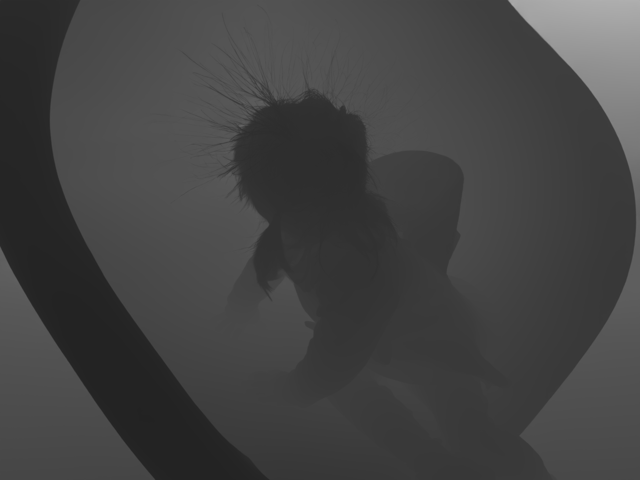

In [ ]:
# Visualize the prediction
# Also romalize to max_depth=4 to make comparison FoV / no FoV models
normalized_depth_no_fov = predicted_depth_no_fov.cpu().numpy() / max_depth
normalized_depth_no_fov = Image.fromarray((normalized_depth_no_fov * 255).astype("uint8"))

normalized_depth_no_fov.resize([640, 480])

### Visualize all together

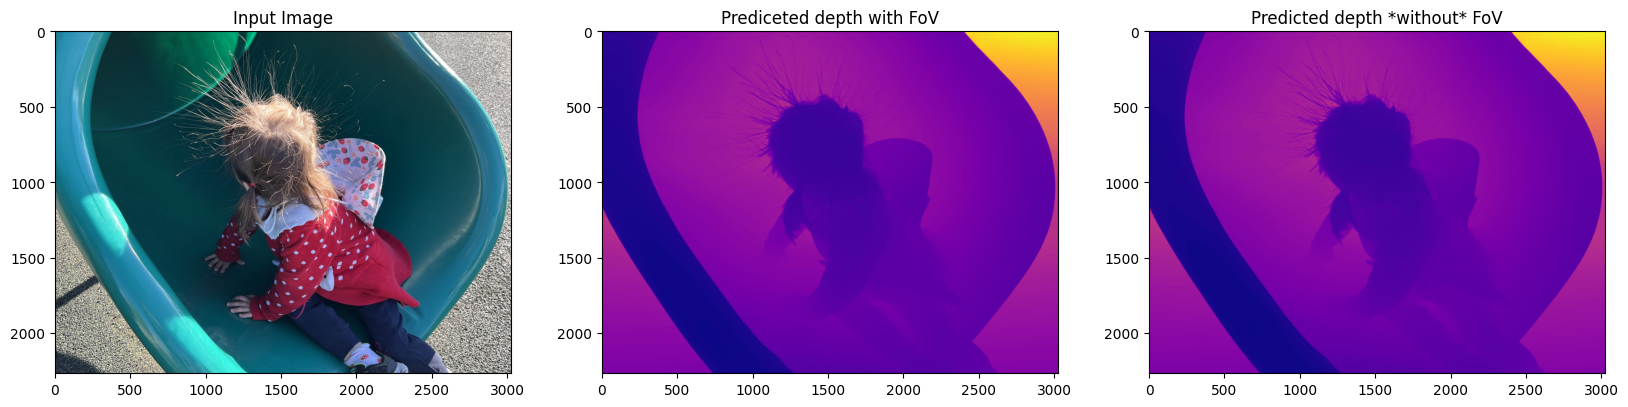

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Prediceted depth with FoV")
plt.imshow(normalized_depth, cmap='plasma')

plt.subplot(1, 3, 3)
plt.title("Predicted depth *without* FoV")
plt.imshow(normalized_depth_no_fov, cmap='plasma')

plt.show()